# Effective Pandas

## Introduction
Within our team, we have well-defined SQL conventions and linters in place to make sure we stick to them. When it comes to data further down the line, we often rely on Jupyter Notebooks for exploratory data analyses. At the top of your notebooks, one of the first things you typically do is importing `pandas`, one of the most powerful, easy to use, and flexible open source data analysis and manipulation tools out there.   

**Challenges**  
Yet pandas' flexibility comes at a cost: the code can be hard to read, oftentimes contains duplicates, and reproducing earlier results is not always obvious, especially in notebook environments in which cells can be executed in an arbitrary order. 


*Illustrative example*

```
df = pd.read_csv('export.csv')
df2 = df[[col1, col3, col9]]  
df2_slice = df2.col3.str.slice(0, 2)  
df2_float = df2_slice.astype('float')  
df2_float['perc'] = df2_float['col3'] * 100  
df_final = df2_float.drop(column=['col3'])  
```

More importantly, ineffective use of pandas can become a bottleneck for your analysis once data volumes grow. After all, pandas requires that you load all your data into RAM so having multiple copies of your data around will not do you any favors. 

**Objective**  
Therefore, Matt Harrison, author of Effective Pandas, suggests various coding *chaining* strategies to apply pandas patterns that are:
1. Easy to read/debug
2. Run faster
3. Take up less memory

In this knowledge share, I'll share some of my lessons learned while reading his [book](https://store.metasnake.com/effective-pandas-book) and demonstrate practical applications relevant in the bol.com landscape. If you prefer video over text, here are some resources you may find helpful instead: (i) [Idiomatic Pandas](https://www.youtube.com/watch?v=Z9ekw2Ou3s0) and (ii) [PyData Meetup](https://www.youtube.com/watch?v=zgbUk90aQ6A).

Hope this is any helpful, learns you some new pandas tips & tricks, and inspires you to apply the chaining principles in your daily work!

Cheers,  
Roy.

## Dataset
For demonstration purposes, I picked a dataset that is highly relevant given the cloud cost savings initiatives going on currently: [`bolcom-pro-pq-master-data-ae7.lego_blocks_v2.base_query_logs_v1`](https://console.cloud.google.com/bigquery?ws=!1m5!1m4!4m3!1sbolcom-pro-pq-master-data-ae7!2slego_blocks_v2!3sbase_query_logs_v1&authuser=1&project=bolcom-pro-asa-12a) which is a collection of all historical BigQuery logs by user and provides information on the costs of these queries. Let's first import all logs from ASA colleagues in the last half a year.

In [1]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(
    "ignore", "Your application has authenticated using end user credentials"
)

def import_data(query, project="bolcom-pro-asa-12a"):
    bq_client = bigquery.Client(project=project)
    return bq_client.query(query=query).to_dataframe()
    
    
# import historical BQ-logs from ASA-colleagues
usernames = ["rberends", "gvanlent", "lvanwijk", "evanvliet", "rkbos", "srustige", "pvanderdoe", "kkonings", "mboerhof", "sroggeveen"]
emails = ", ".join({"'" + username + "@bol.com'" for username in usernames})
query = f"""
        SELECT *
        FROM `bolcom-pro-pq-master-data-ae7.lego_blocks_v2.base_query_logs_v1`
        WHERE 
            date BETWEEN '2022-06-01' AND '2022-11-01'
            AND userId IN ({emails})
        ORDER BY 1, 3
"""
df = import_data(query)

If you inspect the `df`, you'll see the `referencedResources` columns contains a nested strucure. This is because it comprises a list of all direct and indirect tables used within a query. As an example, the following query imports data from a view ([`bolcom-pro-webdata-f6f.sdd_actuals.sdd_webbehaviour_vw`](https://console.cloud.google.com/bigquery?project=bolcom-pro-asa-12a&ws=!1m10!1m4!1m3!1sbolcom-pro-asa-12a!2sbquxjob_1d5c4805_184579eb3a7!3sUS!1m4!4m3!1sbolcom-pro-webdata-f6f!2ssdd_actuals!3ssdd_webbehaviour_vw))..

In [2]:
example_query = df.query('jobId == "projects/bolcom-pro-asa-12a/jobs/bquxjob_7fd64d8b_183d5440dd8"')

(example_query
 ['query']
 [923]
 .replace('\n', ' ')
)                

'SELECT retailerid, session_id, prop20 FROM `bolcom-pro-webdata-f6f.sdd_actuals.sdd_webbehaviour_vw`  WHERE prop20 = "clothing-name-trademark-register" AND visit_date >= "2022-08-05" '

..which in turn builds on one of our lego blocks (`bolcom-pro-pq-master-data-ae7.lego_blocks_v2.base_sdd_webbehaviour_v1`). For that reason, you come across a repeated field for the `referencedResources` column in this case:

In [3]:
(example_query
 ['referencedResources']
 [923]
)

array([{'projectId': 'bolcom-pro-pq-master-data-ae7', 'datasetId': 'lego_blocks_v2', 'tableId': 'base_sdd_webbehaviour_v1', 'id': 'bolcom-pro-pq-master-data-ae7.lego_blocks_v2.base_sdd_webbehaviour_v1', 'type': 'TABLE'},
       {'projectId': 'bolcom-pro-webdata-f6f', 'datasetId': 'sdd_actuals', 'tableId': 'sdd_webbehaviour_vw', 'id': 'bolcom-pro-webdata-f6f.sdd_actuals.sdd_webbehaviour_vw', 'type': 'VIEW'}],
      dtype=object)

Hence the `referencedResources` column stores two sources in the array:

In [4]:
[resource['id'] for resource in example_query['referencedResources'][923]]

['bolcom-pro-pq-master-data-ae7.lego_blocks_v2.base_sdd_webbehaviour_v1',
 'bolcom-pro-webdata-f6f.sdd_actuals.sdd_webbehaviour_vw']

---

**Data Types**  
Now that we have imported the data as a dataframe, let's have a closer look at the data types. By default, pandas attempts to figure out the optimal data type (e.g., `dbdate, datetime, float, boolean`) but in practice it can benefit from some handholding here and there. This especially holds for data classified as `object`.

In [5]:
# inspect types
df.dtypes

jobId                          object
date                           dbdate
datetime               datetime64[ns]
projectId                      object
userId                         object
referencedResources            object
destinationTable               object
query                          object
totalBilledBytes               object
totalCost                     float64
queryType                      object
isProductAnalyst              boolean
dtype: object

Our goal is to minimize the required memory usage for the dataframe without making any changes to the underlying data. As a starting point, our dataframe takes up 162 MB. The `memory_usage()` function returns the number of bytes which is why we still need to divide by a million to get the number of mega bytes (like the Watt to Megawatt conversions you calculated during your physics classes back in the days, don't you remember?). 

Never mind, as you can see, the `query` column (the SQL statement ran by the user) is responsible for the lion share of this memory usage (126 MB).

In [6]:
# memory usage (MB)
(df
 .memory_usage(deep=True)
 .sort_values(ascending=False) 
 .div(1e6)
 .round(2)
)

query                  126.60
destinationTable         8.79
jobId                    6.52
referencedResources      5.39
projectId                4.01
userId                   3.50
totalBilledBytes         3.22
queryType                3.17
date                     0.39
datetime                 0.39
totalCost                0.39
isProductAnalyst         0.10
Index                    0.00
dtype: float64

**Reducing data volume**  
You can often shrink the memory usage of a dataframe by changing the type while not losing any data.
1. Convert numeric data to a format with the appropriate integer/float type
2. Convert low cardinality text data to categorical 


*Numeric data*  
There are various types of integers and floats. Each type has its own lower and upper bound. The wider the range, the more memory the type requires. You can inspect the `min` and `max` values of each type with the `numpy` function `iinfo` (integers) and `finfo` (floats). In the table below, I've also listed these ranges.

In [7]:
# range of integers of type int8
np.iinfo(np.int8)

iinfo(min=-128, max=127, dtype=int8)

| Type | Minimum | Maximum | 
| :--- | :--- | :--- |
| int8 | -128 | 127 | 
| int16 | -32768 | -32768 | 
| int32 | -2147483648 | 2147483647 | 
| int64 | -9223372036854775808 | 9223372036854775808 | 


| Type | Minimum | Maximum | 
| :--- | :--- | :--- |
| float16 | -6.5e+04 | 6.5e+04 | 
| float32 | -3.4e+38 | 3.4e+38 | 
| float64 | -1.8e+308 | 1.8e+308 | 

The idea is that you want to pick the right data types based on the ranges in your dataset. If you pick a type of which your data falls outside of the supported range, it will corrupt your data:

In [8]:
# int8 only runs from -128 to 127 so our -300, -200, 200, and 300 values are off (don't do this!)
pd.Series([-300, -200, -100, 0, 100, 200, 300]).astype('int8')

0    -44
1     56
2   -100
3      0
4    100
5    -56
6     44
dtype: int8

In [9]:
# similarly float 16 only goes as far as 65K: 70K is converted into `inf` (big no no!)
pd.Series([65_000, 70_000]).astype('float16')

0    64992.0
1        inf
dtype: float16

As such, always have a look at the ranges within your dataset and don't forget to think about about the theoretically possible ranges. After all, data is dynamic so always ask yourself the question: *are the supported range by this datatype good enough for future data demands?*

In [10]:
# for example int32 will not do here (34569536405504 > 2147483647)
df.totalBilledBytes.astype('int').max() 

34569536405504

As you can below, this conversion yielded a marginal memory saving of 3 MB (from 162 to 159 MB). Let's see whether we can do better..

In [11]:
(df
 .astype({'totalBilledBytes': 'int64',
          'totalCost': 'float16'}) # the highest query costs are 157 so it's very unlikely it will exceed 65K any time soon
 .memory_usage(deep=True)
 .sum()
) / 1e6

159.330839

Btw, did you notice how we're applying the chaining principle here the author strongly advocates about? Note that we had to wrap our dataframe between brackets, yet by referring to our original `df` (rather than some intermediate result e.g., `df99`) and separating all methods across multiple lines we have improved reproducibility and legibility of our code significantly! You'll come across many more chaining examples in this notebook. Take notice.

*Categorical data*  
Mapping to categorical data pays dividend especially for columns that contain repetitive `object` data (strings). There's nothing like a free lunch, so if all string values are unique it's unlikely to result in memory savings and may even slow things down. Here I picked some columns of which I knew they had repetitive data based on inspecting the head and tail of the dataset. Again, the conversion to categorical data yields only minimal memory savings here (162 → 150 MB).

In [12]:
# object data
(df
 .astype({'projectId': 'category', 
          'userId': 'category', 
          'destinationTable': 'category', 
          'queryType': 'category'})
 .memory_usage(deep=True)
 .sum()
) / 1e6

150.448839

Only later I realized, the `query` column is repetitive in many cases too: this especially holds for daily scheduled queries. For example, if you inspect this gropued dataframe, you see a very long - as in many lines of SQL code - query that ran 1832 times and thus also creates 1832 separate entries in our dataframe. Instead of mapping all these records distinctively, it's more memory efficient to map it as a category.

In [13]:
(df
 .groupby(['queryType', 'userId', 'query'])
 [['jobId']]
 .count()
 .sort_values(by='jobId', ascending=False)
);

In fact, this step is the biggest memory saver we can implement: we reduced memory usage from 162 to 88 MB with just a single line of code!

In [14]:
# convert query column to categorical
(df
 .astype({'query': 'category'})
 .memory_usage(deep=True)
 .sum()
) / 1e6

87.801167

Putting everything together, both numerical and categorical type conversions (and leaving out some redundant columns), we end up at 53 MB for our cleaned dataframe. Now give yourself a pat on the back!

In [15]:
# final result (53 MB)
def preprocess_logs(df):
    return(df
            .astype({'totalBilledBytes': 'int64', 'totalCost': 'float16', 'projectId': 'category', 'userId': 'category', 'destinationTable': 'category', 'queryType': 'category', 'query': 'category'})
            .drop(columns=['jobId', 'date', 'referencedResources', 'destinationTable', 'isProductAnalyst'])
    )

df_cleaned = preprocess_logs(df)

---

## Exploratory Analysis
Since the data is in the right shape now, let's have a closer look at the distribution of `totalCost` to see whether we can make any sense of it.

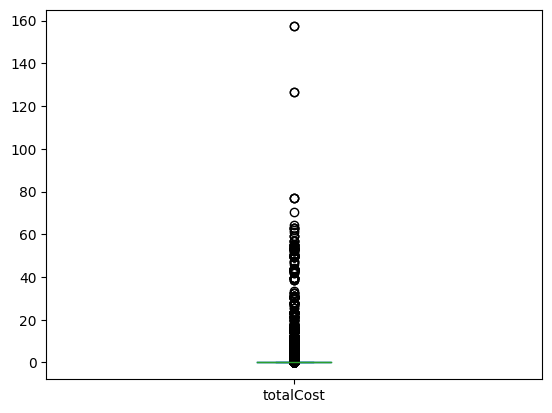

In [16]:
df_cleaned.totalCost.plot.box();

It looks like the data is highly skewed: most queries cost a couple of cents at most, while there are some queries in the tens or even hundreds of euros. For many arithmetic operations (e.g., mean) and statistical tests (e.g., t-test) this will give misleading results. Simply excluding all outliers without any further investigation is usually not the best thing to do either (and academic reviewers will  recklessly tear your analyses apart only if you attempt to). 

Pandas does come with the `clip()` function which allows you to set an upper (and lower) bound for all values in a column. You can set a static value (e.g., all query costs exceeding 75 euro are fixed at 75 euro) or you can choose its value based on the data distribution. Here I have picked the 90th percentile - as a somewhat arbitrary - cut-off point. This basically means the top 10% datapoints will be fixed at the 90th percentile (€1.47): 

In [17]:
df_costs = (
    df_cleaned
    .assign(totalCostFiltered = df_cleaned.totalCost.clip(upper=df_cleaned.totalCost.quantile(.9)))
)

df_costs.query('totalCost != totalCostFiltered').head(5)[['totalCost', 'totalCostFiltered']]

,totalCost,totalCostFiltered
202,14.640625,1.469727
209,3.080078,1.469727
212,39.375000,1.469727
215,2.699219,1.469727
216,39.375000,1.469727


Although this may seem like a good solution on paper, in practice you're making drastical changes to your underlying dataset. For example, here you have essentially created a bi-modal distribution (do you see the second spike around 1.50 euros?. That's a result of our `clip()` operation above and not inherently part of the original dataset).

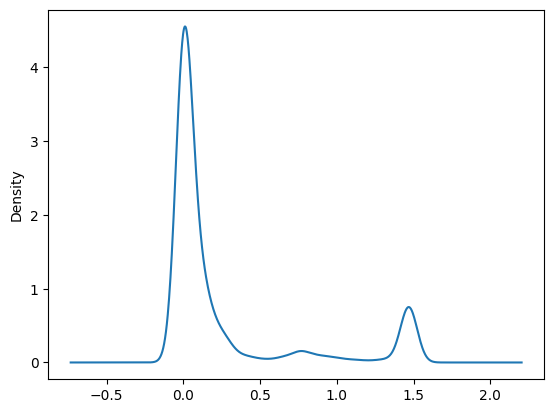

In [18]:
df_costs.totalCostFiltered.plot.kde();

What you can try to do instead is creating various price bins: low, medium, and high cost queries. For skewed data, the default choice is not ideal though: the `pd.cut()` looks at the minimum and maximum values in your dataset and creates equally sized bins. Given the data is heavily right-skewed, 99% of the data would end up in the first bin.

In [19]:
# doesn't work well for skewed data
pd.cut(df_costs['totalCost'], bins=3)

0        (-0.157, 52.417]
1        (-0.157, 52.417]
2        (-0.157, 52.417]
3        (-0.157, 52.417]
4        (-0.157, 52.417]
               ...       
48129    (-0.157, 52.417]
48130    (-0.157, 52.417]
48131    (-0.157, 52.417]
48132    (-0.157, 52.417]
48133    (-0.157, 52.417]
Name: totalCost, Length: 48134, dtype: category
Categories (3, interval[float64, right]): [(-0.157, 52.417] < (52.417, 104.833] < (104.833, 157.25]]

Therefore, it makes more sense to set these boundaries based on the data distribution in this case: low (€0-0.01; 0-50th percentile), medium (€0.01 - 1.47; 50-90th percentile), and high (>€1.47; 90-100th percentile).

In [20]:
%%timeit
(df_costs
 .assign(costClassification=pd.cut(df_costs['totalCost'], 
                                   bins=df_costs['totalCost'].quantile([0, .5, .9, 1]).values, 
                                   labels=["low", "medium", "high"], 
                                   include_lowest=True))
 .head(5)
 [['totalCost', 'costClassification']]
)

3.02 ms ± 12.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In the example above, we used the built-in `pd.cut()` function, but if you're unaware of the existence of that function you might have written your own (see `classify_costs` below) and used it in conjunction with `apply`.

Unlike popular belief, `apply` is not the most efficient solution for numeric data though. Vectorized operations - such as the ones supported by plain pandas - can be an order of magnitude faster depending on the data types and volumes because it's operating at the C-level. If you're using a lot of for-loops in your code you're probably doing things the wrong way. The example below that yields exactly the same output, is almost 5 times as slow as the one above using native pandas.

In [21]:
%%timeit
# slower alternative
def classify_costs(cost, low, medium):
    if cost < low:
        return 'low'
    elif cost < medium:
        return 'medium'
    else:
        return 'high'
    
(df_costs
     .assign(costClassification=df_costs.totalCost.apply(classify_costs,
                                                         low=df_costs['totalCost'].quantile(.5), 
                                                         medium=df_costs['totalCost'].quantile(.9)))
)

16.3 ms ± 216 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


---

**Lambda functions**  
As we saw above, the `.assign()` operator can be a handy tool to add new columns or change existing ones in our chain of commands. One caveat though is that this method always returns a dataframe (i.e., it does not mutate the existing dataframe). So let's say we want to add a boolean `recurringExpensive` that denotes whether a recurring (scheduled/dbt) query is classified as expensive (`costClassification == high`), it raises an error:

In [22]:
(df
 .astype({'totalBilledBytes': 'int64', 'totalCost': 'float16', 'projectId': 'category', 'userId': 'category', 'destinationTable': 'category', 'queryType': 'category', 'query': 'category'})
 .drop(columns=['jobId', 'date', 'referencedResources', 'destinationTable', 'isProductAnalyst'])
 .assign(totalCostFiltered = df.totalCost.clip(upper=df.totalCost.quantile(.9)), 
         costClassification = pd.cut(df['totalCost'], bins=df['totalCost'].quantile([0, .5, .9, 1]).values, labels=["low", "medium", "high"], include_lowest=True),
         recurringExpensive = (df.costClassification == 'high') & (df.queryType.isin(['SCHEDULED QUERY', 'DBT'])))  
)

AttributeError: 'DataFrame' object has no attribute 'costClassification'

The error says that the `costClassification` attribute is missing. Put differently, when we're trying to construct the `recurringExpensive` column in the `assign()` function, it's still unaware of the `costClassification` definition we wrote the line above. Using a lambda function, it'll accept the current state of the dataframe however:

In [23]:
(df
 .astype({'totalBilledBytes': 'int64', 'totalCost': 'float16', 'projectId': 'category', 'userId': 'category', 'destinationTable': 'category', 'queryType': 'category', 'query': 'category'})
 .drop(columns=['jobId', 'date', 'referencedResources', 'destinationTable', 'isProductAnalyst'])
 .assign(totalCostFiltered = df.totalCost.clip(upper=df.totalCost.quantile(.9)), 
         costClassification = pd.cut(df['totalCost'], bins=df['totalCost'].quantile([0, .5, .9, 1]).values, labels=["low", "medium", "high"], include_lowest=True),
         recurringExpensive = lambda df_: (df_.costClassification == 'high') & (df.queryType.isin(['SCHEDULED QUERY', 'DBT'])))  
 .head(5)
);

In other words, if there are dependencies among columns defined within `assign()` always incorporate a `lambda` function.

**Resampling**  
Although it perhaps sounds somewhat contradictory: *no data is also data*. This is to say, if there are no logs on a given date, it means the query count equals 0 (also a data point!). Most analytical methods, however, will not account for these null records at all. For example, if you list the total BigQuery costs for Stef, you'll see that only a handful of records show up between September and November. It, however, does mean that, for example, on September 15 the total costs were 0. Say that you're to calculate Stef's mean daily BQ cost based on this sample, you'd highly overestimate his actual usage!

In [24]:
(df
 .groupby(['userId', 'date'])
 ['totalCost']
 .sum()
 ['srustige@bol.com']
 .sort_index()
)

date
2022-09-14    6.41
2022-09-20    0.53
2022-09-23    3.43
2022-10-07    0.07
2022-10-28    0.00
2022-10-31    0.00
2022-11-01    0.00
Name: totalCost, dtype: float64

One way to go about this, is to group the records on some shared index. This works well as long as all dates in your dataset appear at least once. 

In [25]:
# run the cell without `;` to inspect the output
(df
 .groupby(['userId', 'date'])
 [['totalCost']]
 .sum()
 .unstack('date')
 .fillna(0)
);

A more robust solution, however, is to leverage the `.resample()` method. This also insert a 0 row if, for example, none of the ASA members queried on September 15.

In [26]:
# more robust solution
(df
 [df.userId == 'srustige@bol.com']
 .set_index(['datetime'])
 .resample('1D')
 [['totalCost']]
 .sum()
 .head()
)

,totalCost
datetime,
2022-09-14,6.41
2022-09-15,0.00
2022-09-16,0.00
2022-09-17,0.00
2022-09-18,0.00


---

**Handling missing data**  
In some other cases, you may come across cases where it's not a lack of data that's causing missing dates but the data is really missing, and you cannot fill it with 0s either. 

For demonstration purposes, let's suppose that the total BigQuery costs for September are untrustworthy (after all 37K is a lot of money, isn't it?).

In [27]:
missing_data = (df
 .assign(month = pd.to_datetime(df.date).dt.month)
 .groupby('month')
 [['totalCost']]
 .sum()
 .loc[:10]
)

missing_data

,totalCost
month,
6,1303.24
7,2891.36
8,5794.45
9,36942.29
10,7356.09


For that reason, we set the value for the 9th month to `NaN` (wish I could do that for all my bills):

In [28]:
missing_data.loc[9, 'totalCost'] = np.NaN
missing_data

,totalCost
month,
6,1303.24
7,2891.36
8,5794.45
9,NaN
10,7356.09


It doesn't look so fancy if there are unexpected gaps in your line charts so let's see whether we can impute the missing values. There are various imputation strategies available in pandas. `bfill` will replace missing values with the values from the *next* row, ..

In [29]:
# September now takes the value from October
missing_data.bfill()

,totalCost
month,
6,1303.24
7,2891.36
8,5794.45
9,7356.09
10,7356.09


.. while `ffill()` will replace missing values with values from the *previous* row.

In [30]:
# here September has the same value as August
missing_data.ffill()

,totalCost
month,
6,1303.24
7,2891.36
8,5794.45
9,5794.45
10,7356.09


`interpolate()` takes a slightly different approach by using both pre and post data to estimate the missing value. By default it assumes a linear relationship but you can also set `method=polynomial` if another functional form suits your data better.

In [31]:
# (5794.45 + 7356.09)/2 = 6575.27
missing_data.interpolate()

,totalCost
month,
6,1303.24
7,2891.36
8,5794.45
9,6575.27
10,7356.09


---

**Aggregations while keeping rows**  
As follows from the cell below, roughly half of all queries are "free" (`totalCost = 0.00`): queries that add up to less than one cent. Still, someone chose to undertake an action that led to a query (e.g., inspecting the Preview window in BigQuery). Ideally, we'd like to distinguish such records from other days in which there were no queries at all - which were filled with `0.00` values using our resampling strategy above. For that reason, let's add a new column for the total number of daily queries to our original `df`.

In [32]:
# top 10 totalCost amounts
(df
 .totalCost
 .value_counts(normalize=True)
 .head(10)
)

0.00     0.446587
0.01     0.065941
0.11     0.031392
0.02     0.027797
0.05     0.021149
14.64    0.020630
0.06     0.020090
0.27     0.017431
0.03     0.017431
0.07     0.016973
Name: totalCost, dtype: float64

Before I had read the Effective pandas book, my strategy would have been to create a new dataframe `daily_queries` that contains the number of queries by user for each day and then join it with the original dataframe like this:

In [33]:
%%timeit
daily_queries = (
    df
    .groupby(['userId', 'date'], as_index=False)
    [['jobId']]
    .count()
    .rename(columns={'jobId': 'numQueries'})
)

df.merge(daily_queries, validate='m:1')

22.3 ms ± 453 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


*Side-note:* `pandas` has some built-in validations for entitity relationships such as many to 1 (i.e., each query is only associated with a single total daily count). Really helpful!

There's a more concise and faster way though: the `transform()` method allows you to aggregate data (like the daily query count) whilst still keeping the ungrouped row structure:

In [34]:
%%timeit  # over 3 times faster! (even if you skip the validation part)
(
    df
     .assign(numQueries=df.groupby(['userId', 'date']).transform('size'))
)

5.59 ms ± 95 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Similarly, you can also easily add the daily cost to the dataframe (try it for yourself!).

---

**Selecting columns**  
While we often apply sophisticated query methods to filter on a row level, on a column level this occurs much more rarely. If your data is in wide format (e.g., pivot table) and you want to exclude only a few columns this turns into a tedious jobs. In the example below, I for example want to get rid of all staging (`stg`) tables in `billing_projects` so I manually select all `pro` columns.

In [35]:
billing_projects = (
 df
  .pivot_table(values='totalCost', index='userId', columns='projectId', aggfunc='sum')
  .fillna(0)
)

billing_projects[['bolcom-pro-aq-com-b2c', 'bolcom-pro-asa-12a', 'bolcom-pro-asa-dev-7d6',
       'bolcom-pro-asa-master-api-275', 'bolcom-pro-bipo-training-097',
       'bolcom-pro-commdev-4be', 'bolcom-pro-coreda-ec7',
       'bolcom-pro-corry-801', 'bolcom-pro-ds-commerce-p-1-aa7',
       'bolcom-pro-ds-commerce-p-2-3b2', 'bolcom-pro-ds-commerce-r-2-65d',
       'bolcom-pro-ds-it-platform1-d04', 'bolcom-pro-ds-logistics-1-a72',
       'bolcom-pro-ds-marketing-1-e13', 'bolcom-pro-ds-platform-p1-42d',
       'bolcom-pro-ds-product-1-5d6', 'bolcom-pro-pq-analytics-f1a',
       'bolcom-pro-pq-bigquery-7b8', 'bolcom-pro-pq-master-data-ae7',
       'bolcom-pro-price-variety-56a', 'bolcom-pro-retail-tech-63f',
       'bolcom-pro-rt-betteroffers-d8f', 'bolcom-pro-tb-marketing-1-c80',
       'bolcom-pro-tb-platform-1-429', 'bolcom-pro-tb-product-1-9e9']];

Fortunately, pandas comes with a filter method that let's you use regular expressions on column names:

In [36]:
# cleaner (and more robust!)
billing_projects.filter(like=r'pro');

---

**Smoothing time-series data**  
One of the cool features of pandas is that it comes with matplotlib style functionalities out of the box. The downside, however, is that your plots may need some tweaking (to say the least).

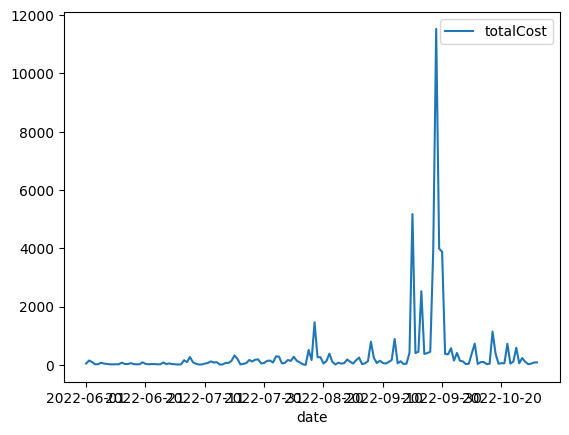

In [37]:
# axes labels overlap, useless legend, lots of 1-day peaks, etc.
(df
 .groupby('date')
 [['totalCost']]
 .sum()
 .plot
 .line()
);

Next, we're going to smoothen daily data so that it becomes the 7-day mean. This will result in a plot that's easier on the eyes. Currently, the daily cost data looks as follows:

In [38]:
daily_cloud_costs = (
 df
 .groupby('date')
 [['totalCost']]
 .sum()
 .fillna(0)
)

daily_cloud_costs.head(7)

,totalCost
date,
2022-06-01,48.56
2022-06-02,151.46
2022-06-03,97.89
2022-06-04,21.42
2022-06-05,22.15
2022-06-06,76.20
2022-06-07,46.90


The smoothing procedure takes the data from the day(s) before, adds it up, and finally calculates the mean based on the number of days.


In [39]:
# note: there's no lagging data for June 1st as it was the start of our sampling frame
daily_cloud_costs.shift(1).head(7)

,totalCost
date,
2022-06-01,NaN
2022-06-02,48.56
2022-06-03,151.46
2022-06-04,97.89
2022-06-05,21.42
2022-06-06,22.15
2022-06-07,76.20


In [40]:
# take the average value of day t and t-1
(
    daily_cloud_costs
    .add(daily_cloud_costs.shift(1))
    .div(2)
    .head()
)

,totalCost
date,
2022-06-01,NaN
2022-06-02,100.010
2022-06-03,124.675
2022-06-04,59.655
2022-06-05,21.785


As you noticed, this becomes quite tedious once you want to add up multiple days of data (e.g., a week), so fortunately pandas comes with a method that takes care of this in one go: `rolling()`. 

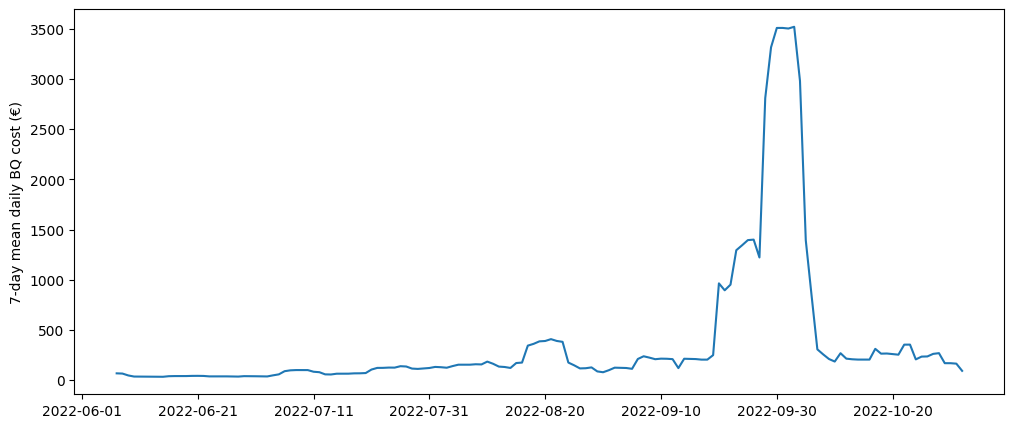

In [41]:
fig, ax = plt.subplots(figsize=(12,5))

(df
 .groupby('date')
 [['totalCost']]
 .sum()
 .rolling(7)  # add the total cost of the 7 days prior and calculate the overall daily mean
 .mean()
 .plot
 .line(ax=ax, legend=None)
)

ax.set_ylabel("7-day mean daily BQ cost (€)")
ax.set_xlabel("");

The rolling method certainly smoothened our dataset, but it also makes it look like the high BigQuery costs late September sustained for a longer period than reality (because an outlier now also impacts proceeding values). In such cases, you may not only want to smoothen a time series but aggregate it on a higher level. The `pd.Grouper()` function makes it very easy to do this (e.g., switch `W` (week) for example to `Q` for quarterly level or `2W` for bi-weekly level data!):

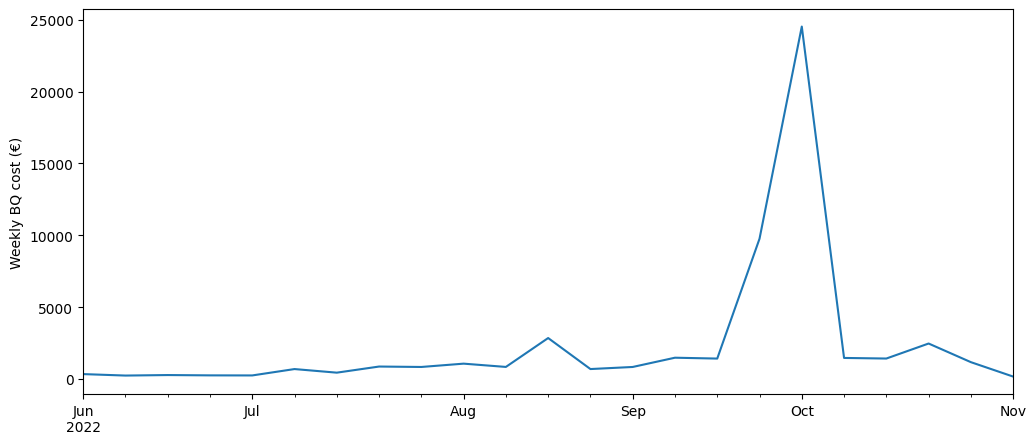

In [42]:
fig, ax = plt.subplots(figsize=(12,5))

(df
  .assign(date=pd.to_datetime(df.date))
  .groupby(pd.Grouper(key='date', freq='W'))
  [['totalCost']]
  .sum()
  .plot(ax=ax, legend=None)
)

ax.set_ylabel("Weekly BQ cost (€)")
ax.set_xlabel("");

---

## Exporting Data
After conducting your analysis in pandas, you may want to update your business stakeholders with an export of the data in CSV or Excel format. Although this gets the job done, both data formats have some inherent limitations. 

Fortunately, for internal use (e.g., saving intermediate results) there exist better alternatives. For example, if you want to pick up the analysis you worked on the day before and don't want to have to run your notebook top to bottom every time. As the table below demonstrates, in such cases you should highly consider saving data in another format: CSV data has - by far - the largest file size and slowest write/read speed.

| Filetype | Filesize (MB) | Memory (MB) | Write (s) | Read (s) | 
| :--- | :--- | :--- | :--- | :--- | 
| CSV | 124 | 2.6 | 1.3 | 0.7 |
| Pickle | 43 | 1.2 | 0.02 | 0.02|
| Parquet | 6 | 1.8 | 0.09 | 0.08 |
| Feather | 4 | 1.7 | 0.04 | 0.06 |

Unlike the other file types, CSV also does not preserve the data types specified in the source. For example, once you import the `bq_logs.csv` file (see below), you need to re-assign the categories (and even the datetime format). Although this relatively small data set does not make a strong argument, it's generally said that `feather` is better for *short-term* storage (=fast to read and write but creates slightly larger file sizes) while `parquet` is better for long-term storage as it's file sizes are smallest. 

In the Appendix below you can try it out for yourself (of course the read/write speed may deviate a bit depending on your own machine).

Happy waiting!

---
## Appendix

In [43]:
# create a new folder for our data exports (if it does not exist yet)
from pathlib import Path
Path("./export").mkdir(parents=True, exist_ok=True)

**CSV**

In [44]:
%%timeit
df_cleaned.to_csv('export/bq_logs.csv', index=False)

1.35 s ± 12.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
df_csv = pd.read_csv('export/bq_logs.csv')
df_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48134 entries, 0 to 48133
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   datetime          48134 non-null  object 
 1   projectId         48134 non-null  object 
 2   userId            48134 non-null  object 
 3   query             48134 non-null  object 
 4   totalBilledBytes  48134 non-null  int64  
 5   totalCost         48134 non-null  float64
 6   queryType         48134 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 2.6+ MB


**Pickle**

In [46]:
%%timeit
df_cleaned.to_pickle('export/bq_logs.pickle')

20.3 ms ± 2.9 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [47]:
df_pickle = pd.read_pickle('export/bq_logs.pickle')
df_pickle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48134 entries, 0 to 48133
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          48134 non-null  datetime64[ns]
 1   projectId         48134 non-null  category      
 2   userId            48134 non-null  category      
 3   query             48134 non-null  category      
 4   totalBilledBytes  48134 non-null  int64         
 5   totalCost         48134 non-null  float16       
 6   queryType         48134 non-null  category      
dtypes: category(4), datetime64[ns](1), float16(1), int64(1)
memory usage: 1.2 MB


**Parquet**

In [48]:
# throws an error... ooopsh!!!
# df_cleaned.to_parquet('export/bq_logs.parquet')

In [49]:
# let's convert float16 to float32 (or float64) to solve it!
df_cleaned_float32 = (df_cleaned.astype({'totalCost': 'float32'}))

In [50]:
%%timeit
df_cleaned_float32.to_parquet('export/bq_logs.parquet')

94.4 ms ± 4.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
df_parquet = pd.read_parquet('export/bq_logs.parquet')
df_parquet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48134 entries, 0 to 48133
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          48134 non-null  datetime64[ns]
 1   projectId         48134 non-null  category      
 2   userId            48134 non-null  category      
 3   query             48134 non-null  category      
 4   totalBilledBytes  48134 non-null  int64         
 5   totalCost         48134 non-null  float32       
 6   queryType         48134 non-null  category      
dtypes: category(4), datetime64[ns](1), float32(1), int64(1)
memory usage: 1.8 MB


**Feather**

In [52]:
%%timeit 
df_cleaned.to_feather('export/bq_logs.feather')

39.9 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [53]:
df_feather = pd.read_feather('export/bq_logs.feather')
df_feather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48134 entries, 0 to 48133
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          48134 non-null  datetime64[ns]
 1   projectId         48134 non-null  category      
 2   userId            48134 non-null  category      
 3   query             48134 non-null  category      
 4   totalBilledBytes  48134 non-null  int64         
 5   totalCost         48134 non-null  float16       
 6   queryType         48134 non-null  category      
dtypes: category(4), datetime64[ns](1), float16(1), int64(1)
memory usage: 1.7 MB
